In [1]:
import os
import pyspark
conf = pyspark.SparkConf()

conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','7g')
sc = pyspark.SparkContext(conf=conf)

spark = pyspark.SQLContext.getOrCreate(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/16 21:05:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/envs/bigdata/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Goal is to predict the Arrival Delay of flights 


In [2]:

# Got the DATA from DOT website 
# Reading the Data  CSV file 
# NOTE   null value in the file is NA so thats why we pass it down here 

import pyspark
df = spark.read.csv("2008.csv.bz2", header=True, inferSchema=True, nullValue='NA')
df.printSchema()

 

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)

In [8]:
df.show(20)

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|2008|    1|         3|        4|   1343|      1325|   1451|      1435|           WN|      588

In [9]:

shape = ((df.count(), len(df.columns)))  
#prints the shape
print('The shape of flights_df:', shape)

The shape of flights_df: (2389217, 29)


/opt/conda/envs/bigdata/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


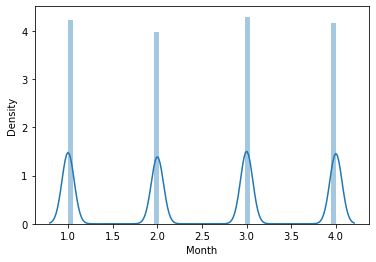

In [10]:
import seaborn as sns


flights_df_sample = df.sample(True, 0.5, 42)
flights_df_sample_pandas = flights_df_sample.toPandas() #create sample for being able to create proper visualizations on the dataset

#create visualizations for relevant features to understand the data
sns.distplot(flights_df_sample_pandas['Month'])
display()


/opt/conda/envs/bigdata/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/bigdata/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


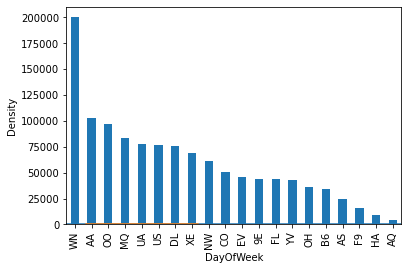

In [11]:
sns.distplot(flights_df_sample_pandas['DayofMonth'])
display()


sns.distplot(flights_df_sample_pandas['DayOfWeek'])
display()


flights_df_sample_pandas['UniqueCarrier'].value_counts().plot(kind='bar')
display()

# Data Preparations 

# How many  features we have

In [12]:
# we have 29 columns 

df.columns

len(df.columns)

29

In [ ]:
# count the number of flights in the file 

df.count()


# Remove Duplicates 

In [13]:

# check if we have duplicated rows 

df.distinct().count()

2389213

In [14]:
# Remove Duplicate Rows 

df=df.drop_duplicates()

df.count()

2389213

# Delete Rows where  Delay time  is not available  [ ArrivalDelay column ] 


In [3]:
# Delete Rows where  Delay time  is not available  [ ArrivalDelay column ] 
from pyspark.sql.functions import isnan, when, count, col

df1=df.where(col('ArrDelay').isNotNull())

df1.count()

2319121

In [4]:
# Delete Rows where  Delay time  is not available [ DepartureDelay column ]
from pyspark.sql.functions import isnan, when, count, col

df2=df1.where(col('DepDelay').isNotNull())

df2.count()

2319121

# Notice that some columns have 1 distinct value and will not make a difference in our prediction , drop columns 

In [5]:

from pyspark.sql.functions import isnan, when, count, col,countDistinct

# apply countDistinct on each column

col_counts = df2.agg(*(countDistinct(col(c)).alias(c) for c in df2.columns)).collect()[0].asDict()

# select the cols with count=1 in an array
cols_to_drop = [col for col in df2.columns if col_counts[col] == 1 ]

# drop the selected column
#df2=df2.drop(*cols_to_drop).show()

22/05/16 20:43:47 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
# Columns have one Value  that we need to drop. 
cols_to_drop

['Year', 'Cancelled', 'Diverted']

In [ ]:
# column counts and its distinct values 

col_counts  

In [5]:
# drop columns with 1  value


df3=df2.drop("Year") \
                .drop("Cancelled") \
                .drop("CancellationCode") \
                .drop("Diverted") 

# now we have 25 columns. 
df3.columns



['Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'UniqueCarrier',
 'FlightNum',
 'TailNum',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Origin',
 'Dest',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [20]:
len(df3.columns)

25

# Our goal is to predict the Arrival Delay of flights , therefore there are some variables that are forbiden to use in our prediction since their values are only knows once the plane take off. 

# Drop the following columns:-
# [ArrTime, ActualElapsedTime, AirTime,   TaxiIn,   Diverted,   CarrierDelay, WeatherDelay,   NASDelay,   SecurityDelay and LateAircraftDelay]

In [6]:
df4=df3.drop("ActualElapsedTime") \
                .drop("ArrTime") \
                .drop("AirTime") \
                .drop("TaxiIn") \
                .drop("Diverted") \
                .drop("CarrierDelay") \
                .drop("WeatherDelay") \
                .drop("NASDelay") \
                .drop("SecurityDelay") \
                .drop("LateAircraftDelay") \
                .drop("FlightNum") \
                .drop("TailNum") \
                .drop("CRSElapsedTime") \
                .drop("TaxiOut") 



# After dropping columns  we end up with 16 features 

df4.columns 
len(df4.columns)   


12

In [22]:
df4.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)



In [ ]:
df4

# Check Missing Values


In [23]:
# I am trying to check if a column has more than 25 %  of NA values i will drop the column or can replace with Mean /  average 
from pyspark.sql.functions import *

amount_missing_df = df4.select([(count(when(isnan(c) | col(c).isNull(), c))/count(lit(1))).alias(c) for c in df4.columns])
amount_missing_df.show()

+-----+----------+---------+-------+----------+----------+-------------+--------+--------+------+----+--------+
|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|ArrDelay|DepDelay|Origin|Dest|Distance|
+-----+----------+---------+-------+----------+----------+-------------+--------+--------+------+----+--------+
|  0.0|       0.0|      0.0|    0.0|       0.0|       0.0|          0.0|     0.0|     0.0|   0.0| 0.0|     0.0|
+-----+----------+---------+-------+----------+----------+-------------+--------+--------+------+----+--------+



In [ ]:
#amount_missing_df.select('CRSElapsedTime', 'DepTime' , 'ArrTime')

In [ ]:
#amount_missing_df.select('CRSArrTime', 'UniqueCarrier' , 'FlightNum','TailNum')


In [ ]:
#amount_missing_df.select('ActualElapsedTime', 'CRSElapsedTime' , 'Origin','Dest', 'Distance')


# Correlation of features/Columns  only  numeric variables


In [ ]:
# Correlation using Pyspark 

In [24]:
df4.stat.corr('DepDelay','ArrDelay')

0.9336708645281276

In [9]:

# transfering our dataframe into Panda datafram to get the correlation  Matrix 
pandasdf= df4.toPandas()


In [10]:
# https://datagy.io/python-correlation-matrix/

matrix=pandasdf.corr().round(2)
matrix

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,ArrDelay,DepDelay,Distance
Month,1.00,-0.00,-0.00,-0.01,-0.00,-0.01,-0.03,-0.03,0.00
DayofMonth,-0.00,1.00,-0.04,-0.00,-0.00,-0.00,-0.02,-0.02,-0.00
DayOfWeek,-0.00,-0.04,1.00,0.01,0.01,0.01,-0.00,0.01,0.02
DepTime,-0.01,-0.00,0.01,1.00,0.97,0.78,0.18,0.21,-0.02
CRSDepTime,-0.00,-0.00,0.01,0.97,1.00,0.78,0.11,0.13,-0.01
CRSArrTime,-0.01,-0.00,0.01,0.78,0.78,1.00,0.10,0.13,0.04
ArrDelay,-0.03,-0.02,-0.00,0.18,0.11,0.10,1.00,0.93,-0.01
DepDelay,-0.03,-0.02,0.01,0.21,0.13,0.13,0.93,1.00,0.02
Distance,0.00,-0.00,0.02,-0.02,-0.01,0.04,-0.01,0.02,1.00


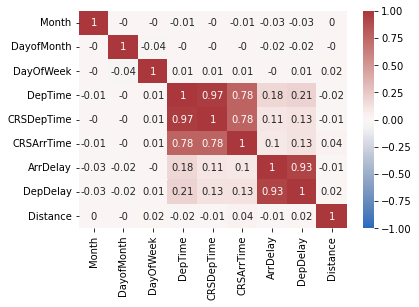

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.heatmap(matrix, annot=True , vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()

# Since we want to select strong relationships, we need to be able to select values 
# greater than or equal to 0.7 and less than or equal to -0.7 Since this would make our 
# selection statement more complicated, we can simply filter on the absolute value of our correlation coefficient.


In [28]:
from  pyspark.sql.functions import abs

matrix = matrix.unstack()


matrix = matrix[(matrix) >= 0.7]

print(matrix)

Month       Month         1.00
DayofMonth  DayofMonth    1.00
DayOfWeek   DayOfWeek     1.00
DepTime     DepTime       1.00
            CRSDepTime    0.97
            CRSArrTime    0.78
CRSDepTime  DepTime       0.97
            CRSDepTime    1.00
            CRSArrTime    0.78
CRSArrTime  DepTime       0.78
            CRSDepTime    0.78
            CRSArrTime    1.00
ArrDelay    ArrDelay      1.00
            DepDelay      0.93
DepDelay    ArrDelay      0.93
            DepDelay      1.00
Distance    Distance      1.00
dtype: float64


In [ ]:
# Based on Correlation Matrix we only  choose the features that has strong correlation with our Target Variable ArrDelay
# The strongest correlation are with  DepDelay  , DepTime, CRSDepTime and CRSArrTime , But first i will use 12 features 
# and evaluate the AUC of my linear regression 

In [ ]:
df4


# Define Arrival Delay  for the flight... > 15 minutes of its scheduled arrival

In [7]:
from pyspark.sql import functions as fn

#set up a threshold for the delay time and create like a Binary column 0/1

df4 = df4.withColumn("Flight_Delayed", fn.when(fn.col("DepDelay")<15, 0).otherwise(1))

df4

Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,ArrDelay,DepDelay,Origin,Dest,Distance,Flight_Delayed
1,3,4,1343,1325,1435,WN,16,18,HOU,LIT,393,1
1,3,4,1125,1120,1245,WN,2,5,HOU,MAF,441,0
1,3,4,2009,2015,2140,WN,-4,-6,HOU,MAF,441,0
1,3,4,903,855,1205,WN,-2,8,HOU,MCO,848,0
1,3,4,1423,1400,1710,WN,16,23,HOU,MCO,848,1
1,3,4,2024,2020,2325,WN,0,4,HOU,MCO,848,0
1,3,4,1753,1745,2050,WN,3,8,HOU,MCO,848,0
1,3,4,622,620,930,WN,5,2,HOU,MCO,848,0
1,3,4,1944,1945,2215,WN,-5,-1,HOU,MDW,937,0
1,3,4,1453,1425,1650,WN,26,28,HOU,MDW,937,1


In [13]:
df4.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- Flight_Delayed: integer (nullable = false)



# Models Logistic Regression

# But the model needs all features to be in number format so we need to change the string col to  int using stringIndexer and OneHotEncoder

# Encode Categorical Variables


In [8]:
#perform string index, which prevents creation of new columns for the dummy variables and perform one hot encoding
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

indexer = StringIndexer(inputCol="UniqueCarrier", outputCol="UniqueCarrier_Numeric")
df4 = indexer.fit(df4).transform(df4)

encoder=OneHotEncoder(inputCol="UniqueCarrier_Numeric", outputCol="UniqueCarrier_OHE")
df4= encoder.fit(df4).transform(df4)


indexer = StringIndexer(inputCol="Origin", outputCol="Origin_Numeric")
df4 = indexer.fit(df4).transform(df4)

encoder=OneHotEncoder(inputCol="Origin_Numeric", outputCol="Origin_OHE")
df4= encoder.fit(df4).transform(df4)



indexer = StringIndexer(inputCol="Dest", outputCol="Dest_Numeric")
df4 = indexer.fit(df4).transform(df4)

encoder=OneHotEncoder(inputCol="Dest_Numeric", outputCol="Dest_OHE")
df4= encoder.fit(df4).transform(df4)

df4 = df4.drop('ArrDelay')


df4

Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,DepDelay,Origin,Dest,Distance,Flight_Delayed,UniqueCarrier_Numeric,UniqueCarrier_OHE,Origin_Numeric,Origin_OHE,Dest_Numeric,Dest_OHE
1,3,4,1343,1325,1435,WN,18,HOU,LIT,393,1,0.0,"(19,[0],[1.0])",39.0,"(290,[39],[1.0])",79.0,"(290,[79],[1.0])"
1,3,4,1125,1120,1245,WN,5,HOU,MAF,441,0,0.0,"(19,[0],[1.0])",39.0,"(290,[39],[1.0])",119.0,"(290,[119],[1.0])"
1,3,4,2009,2015,2140,WN,-6,HOU,MAF,441,0,0.0,"(19,[0],[1.0])",39.0,"(290,[39],[1.0])",119.0,"(290,[119],[1.0])"
1,3,4,903,855,1205,WN,8,HOU,MCO,848,0,0.0,"(19,[0],[1.0])",39.0,"(290,[39],[1.0])",11.0,"(290,[11],[1.0])"
1,3,4,1423,1400,1710,WN,23,HOU,MCO,848,1,0.0,"(19,[0],[1.0])",39.0,"(290,[39],[1.0])",11.0,"(290,[11],[1.0])"
1,3,4,2024,2020,2325,WN,4,HOU,MCO,848,0,0.0,"(19,[0],[1.0])",39.0,"(290,[39],[1.0])",11.0,"(290,[11],[1.0])"
1,3,4,1753,1745,2050,WN,8,HOU,MCO,848,0,0.0,"(19,[0],[1.0])",39.0,"(290,[39],[1.0])",11.0,"(290,[11],[1.0])"
1,3,4,622,620,930,WN,2,HOU,MCO,848,0,0.0,"(19,[0],[1.0])",39.0,"(290,[39],[1.0])",11.0,"(290,[11],[1.0])"
1,3,4,1944,1945,2215,WN,-1,HOU,MDW,937,0,0.0,"(19,[0],[1.0])",39.0,"(290,[39],[1.0])",23.0,"(290,[23],[1.0])"
1,3,4,1453,1425,1650,WN,28,HOU,MDW,937,1,0.0,"(19,[0],[1.0])",39.0,"(290,[39],[1.0])",23.0,"(290,[23],[1.0])"


In [9]:
df4.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- Flight_Delayed: integer (nullable = false)
 |-- UniqueCarrier_Numeric: double (nullable = false)
 |-- UniqueCarrier_OHE: vector (nullable = true)
 |-- Origin_Numeric: double (nullable = false)
 |-- Origin_OHE: vector (nullable = true)
 |-- Dest_Numeric: double (nullable = false)
 |-- Dest_OHE: vector (nullable = true)



# split our ready  dataset into training and testing dataset. 
# Also check for imblance in the dataset. 


In [10]:
# splitting the data  test /  training 


#Also checking if  dataset is imbalanced

#perform undersampling for the preparation of the data
#split the train test data
training_df, testing_df = df4.randomSplit([0.9, 0.1], seed=5)

#create major and minor DF to check the number of delayed and not delayed flights in our dataset 
major_df = training_df.filter(col("Flight_Delayed") == 0)
minor_df = training_df.filter(col("Flight_Delayed") == 1)
ratio = major_df.count()/minor_df.count()

#create the balanced dataset for training the model
sampled_majority_df = major_df.sample(False, 1.2/ratio, seed=5)

combined_df_2 = sampled_majority_df.unionAll(minor_df)

#shows the count of balanced dataframe
combined_df_2.groupBy('Flight_Delayed').agg(fn.count('*')).show()




+--------------+--------+
|Flight_Delayed|count(1)|
+--------------+--------+
|             0|  543098|
|             1|  452619|
+--------------+--------+



In [24]:
ratio

3.61261237376248

In [11]:
major_df.count()

1635137

In [12]:
minor_df.count()

452619

In [13]:
sampled_majority_df


Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,DepDelay,Origin,Dest,Distance,Flight_Delayed,UniqueCarrier_Numeric,UniqueCarrier_OHE,Origin_Numeric,Origin_OHE,Dest_Numeric,Dest_OHE
1,1,2,2,2355,532,F9,7,DEN,FLL,1703,0,17.0,"(19,[17],[1.0])",3.0,"(290,[3],[1.0])",28.0,"(290,[28],[1.0])"
1,1,2,2,2355,755,B6,7,PDX,JFK,2454,0,15.0,"(19,[15],[1.0])",38.0,"(290,[38],[1.0])",16.0,"(290,[16],[1.0])"
1,1,2,6,2355,505,F9,11,DEN,JAX,1447,0,17.0,"(19,[17],[1.0])",3.0,"(290,[3],[1.0])",53.0,"(290,[53],[1.0])"
1,1,2,8,2354,510,US,14,LAS,MSP,1300,0,4.0,"(19,[4],[1.0])",7.0,"(290,[7],[1.0])",12.0,"(290,[12],[1.0])"
1,1,2,8,2359,800,B6,9,SEA,JFK,2421,0,15.0,"(19,[15],[1.0])",19.0,"(290,[19],[1.0])",16.0,"(290,[16],[1.0])"
1,1,2,9,2355,652,US,14,LAS,PIT,1910,0,4.0,"(19,[4],[1.0])",7.0,"(290,[7],[1.0])",45.0,"(290,[45],[1.0])"
1,1,2,21,30,831,B6,-9,ONT,JFK,2430,0,15.0,"(19,[15],[1.0])",48.0,"(290,[48],[1.0])",16.0,"(290,[16],[1.0])"
1,1,2,33,30,605,NW,3,LAX,MSP,1536,0,8.0,"(19,[8],[1.0])",4.0,"(290,[4],[1.0])",12.0,"(290,[12],[1.0])"
1,1,2,35,40,500,AA,-5,LAS,DFW,1055,0,1.0,"(19,[1],[1.0])",7.0,"(290,[7],[1.0])",2.0,"(290,[2],[1.0])"
1,1,2,44,45,612,DL,-1,PHX,ATL,1587,0,6.0,"(19,[6],[1.0])",5.0,"(290,[5],[1.0])",0.0,"(290,[0],[1.0])"


In [28]:
# Models to use  and each accuracy  evaluation for it 



In [14]:
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as sf
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import RegexTokenizer
import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import concat, col, lit, lower
from pyspark.sql.functions import isnan, when, count, col, isnull
from pyspark.sql.functions import concat_ws
from  pyspark.sql.functions import abs
# seting master("local[*]") enables multicore processing on all available logical cores on your machine
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml import evaluation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import evaluation
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler

22/05/16 21:26:51 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/16 21:26:51 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
/opt/conda/envs/bigdata/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


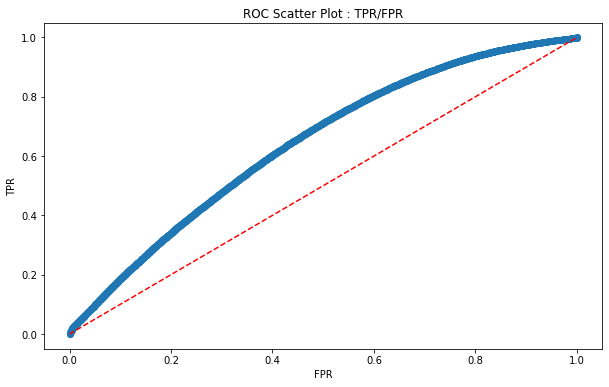

In [15]:
#implementation of prepared and undersampled dataset for the model implementation


#  VA is a transformer combines list of columns into a single vector column to train ML models 
# combine our features into one vector 



#create a vector assembler
va = VectorAssembler(
    inputCols=["Month", "DayofMonth", "DayOfWeek", "UniqueCarrier_OHE", "Origin_OHE", "Dest_OHE", "CRSDepTime", "CRSArrTime"], outputCol="features")




#train a logistic model
lr = LogisticRegression(featuresCol='features', labelCol='Flight_Delayed', regParam=0.2, elasticNetParam=0.1, threshold=0.45, thresholds=[0.55, 0.45])
lr_pipeline = Pipeline(stages=[va, lr])
lr_model = lr_pipeline.fit(combined_df_2)
lr_transform = lr_model.transform(testing_df)

#logistic model metric evaluation

#AUC score
bce = BinaryClassificationEvaluator(labelCol='Flight_Delayed', metricName='areaUnderROC')
score_auc=bce.evaluate(lr_transform)

#Recall  =  ( TP / TP + FN )

#The focus of recall is actual positive classes. It indicates how many of the positive classes the model is able to predict correctly.

lr_evaluator_recall = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="weightedRecall")
score_recall=lr_evaluator_recall.evaluate(lr_model.transform(testing_df))

#Precision  = (  TP / TP + FP )

# The focus of precision is positive predictions. It indicates how many of the positive predictions are true.


lr_evaluator_precision = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="weightedPrecision")
score_precision=lr_evaluator_precision.evaluate(lr_model.transform(testing_df))


#accuracy
lr_evaluator_accuracy = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="accuracy")
score_accuracy=lr_evaluator_accuracy.evaluate(lr_model.transform(testing_df))

#f1 
lr_evaluator_accuracy = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="f1")
score_f1=lr_evaluator_accuracy.evaluate(lr_model.transform(testing_df))

#shows the scatterplot    TPR  true positive rate      FPR  false postive Rate 
# ROC  receiver operating characteristic curve is a performance measuer 
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'r--')
plt.scatter(lr_model.stages[-1].summary.roc.select('FPR').collect(),
            lr_model.stages[-1].summary.roc.select('TPR').collect())
plt.title('ROC Scatter Plot : TPR/FPR')
plt.xlabel('FPR')
plt.ylabel('TPR')
display()


In [16]:
scores = [score_auc, score_recall, score_accuracy, score_f1, score_precision]
metricName = ['AUC', 'Recall', 'Accuracy', 'f1', 'Precision']
metric_df = pd.DataFrame(zip(metricName,scores),index=[1,2,3,4,5],columns=['Metric Name', 'Score'])
metric_df.head(5)

,Metric Name,Score
1,AUC,0.641699
2,Recall,0.580330
3,Accuracy,0.580330
4,f1,0.617519
5,Precision,0.730110


In [17]:
# our prediction  using testing dataset 

lr_transform

Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,DepDelay,Origin,Dest,Distance,Flight_Delayed,UniqueCarrier_Numeric,UniqueCarrier_OHE,Origin_Numeric,Origin_OHE,Dest_Numeric,Dest_OHE,features,rawPrediction,probability,prediction
1,1,2,3,2315,717,UA,48,OAK,IAD,2408,1,5.0,"(19,[5],[1.0])",29.0,"(290,[29],[1.0])",27.0,"(290,[27],[1.0])","(604,[0,1,2,8,51,...",[0.08184585473893...,[0.52045004915548...,1.0
1,1,2,11,2107,54,UA,184,JFK,SFO,2586,1,5.0,"(19,[5],[1.0])",15.0,"(290,[15],[1.0])",13.0,"(290,[13],[1.0])","(604,[0,1,2,8,37,...",[0.32051114194380...,[0.57944881630406...,0.0
1,1,2,20,2359,118,US,21,LAS,SAN,258,1,4.0,"(19,[4],[1.0])",7.0,"(290,[7],[1.0])",22.0,"(290,[22],[1.0])","(604,[0,1,2,7,29,...",[0.25684113778473...,[0.56385961556870...,0.0
1,1,2,26,2255,135,B6,91,FLL,JFK,1069,1,15.0,"(19,[15],[1.0])",28.0,"(290,[28],[1.0])",16.0,"(290,[16],[1.0])","(604,[0,1,2,18,50...",[0.24931787398027...,[0.56200859930905...,0.0
1,1,2,28,2340,727,US,48,LAS,PHL,2176,1,4.0,"(19,[4],[1.0])",7.0,"(290,[7],[1.0])",20.0,"(290,[20],[1.0])","(604,[0,1,2,7,29,...",[0.10964306815353...,[0.52738333989784...,1.0
1,1,2,29,2145,2230,WN,164,TPA,PBI,174,1,0.0,"(19,[0],[1.0])",25.0,"(290,[25],[1.0])",54.0,"(290,[54],[1.0])","(604,[0,1,2,3,47,...",[-0.2417466860297...,[0.43985595241892...,1.0
1,1,2,33,35,603,CO,-2,SFO,IAH,1635,0,9.0,"(19,[9],[1.0])",13.0,"(290,[13],[1.0])",6.0,"(290,[6],[1.0])","(604,[0,1,2,12,35...",[0.89242354432947...,[0.70939005372734...,0.0
1,1,2,33,2125,2330,MQ,188,ORD,OKC,693,1,3.0,"(19,[3],[1.0])",1.0,"(290,[1],[1.0])",58.0,"(290,[58],[1.0])","(604,[0,1,2,6,23,...",[-0.4578235676181...,[0.38750226094071...,1.0
1,1,2,37,40,753,DL,-3,SEA,CVG,1964,0,6.0,"(19,[6],[1.0])",19.0,"(290,[19],[1.0])",21.0,"(290,[21],[1.0])","(604,[0,1,2,9,41,...",[0.85284869249785...,[0.70116437909894...,0.0
1,1,2,51,2359,756,US,52,LAS,EWR,2227,1,4.0,"(19,[4],[1.0])",7.0,"(290,[7],[1.0])",10.0,"(290,[10],[1.0])","(604,[0,1,2,7,29,...",[0.02723263280756...,[0.50680773747967...,1.0


# Random Forest Model 

In [21]:
# Fitting a random forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='Flight_Delayed')
rf_pipeline = Pipeline(stages=[va, rf])
rf_model = rf_pipeline.fit(combined_df_2)
rf_transform = rf_model.transform(testing_df)

#Random Forest metric evaluation

#AUC score
rf_bce = BinaryClassificationEvaluator(labelCol="Flight_Delayed", metricName='areaUnderROC')
score_auc=rf_bce.evaluate(rf_transform)

#Recall
rf_evaluator_recall = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="weightedRecall")
score_recall=rf_evaluator_recall.evaluate(rf_transform)

#Precision
rf_evaluator_precision = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="weightedPrecision")
score_precision=rf_evaluator_precision.evaluate(rf_transform)

#accuracy
rf_evaluator_accuracy = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="accuracy")
score_accuracy=rf_evaluator_accuracy.evaluate(rf_transform)

#f1 
rf_evaluator_accuracy = evaluation.MulticlassClassificationEvaluator(labelCol="Flight_Delayed", metricName="f1")
score_f1=rf_evaluator_accuracy.evaluate(rf_transform)


In [22]:

# dataframe with all the metrics of random forest model
scores = [score_auc, score_recall, score_accuracy, score_f1, score_precision]
metricName = ['AUC', 'Recall', 'Balanced Accuracy', 'f1', 'Precision']
metric_df = pd.DataFrame(zip(metricName,scores),index=[1,2,3,4,5],columns=['Metric Name', 'Score'])
metric_df.head(5)

,Metric Name,Score
1,AUC,0.660715
2,Recall,0.770047
3,Balanced Accuracy,0.770047
4,f1,0.723754
5,Precision,0.714401
